In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,roc_auc_score
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [115]:
pd.set_option("display.max_column",None)
sns.set_style("whitegrid")

In [116]:
master_df = pd.read_csv('german_credit_data.csv')

In [117]:
master_df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [118]:
master_df.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [119]:
master_df = master_df.dropna().reset_index(drop = True)
master_df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
1,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
2,4,53,male,2,free,little,little,4870,24,car,bad
3,7,35,male,3,rent,little,moderate,6948,36,car,good
4,9,28,male,3,own,little,moderate,5234,30,car,bad


In [120]:
master_df.drop(columns = "Unnamed: 0",inplace = True)
master_df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,female,2,own,little,moderate,5951,48,radio/TV,bad
1,45,male,2,free,little,little,7882,42,furniture/equipment,good
2,53,male,2,free,little,little,4870,24,car,bad
3,35,male,3,rent,little,moderate,6948,36,car,good
4,28,male,3,own,little,moderate,5234,30,car,bad


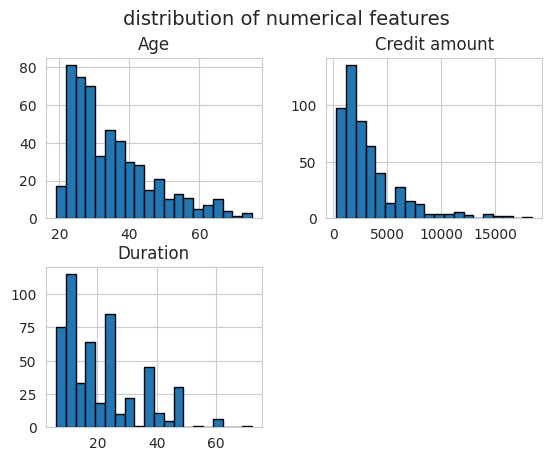

In [121]:
master_df[["Age","Credit amount","Duration"]].hist(bins = 20,edgecolor = "black")
plt.suptitle("distribution of numerical features",fontsize = 14)
plt.show()

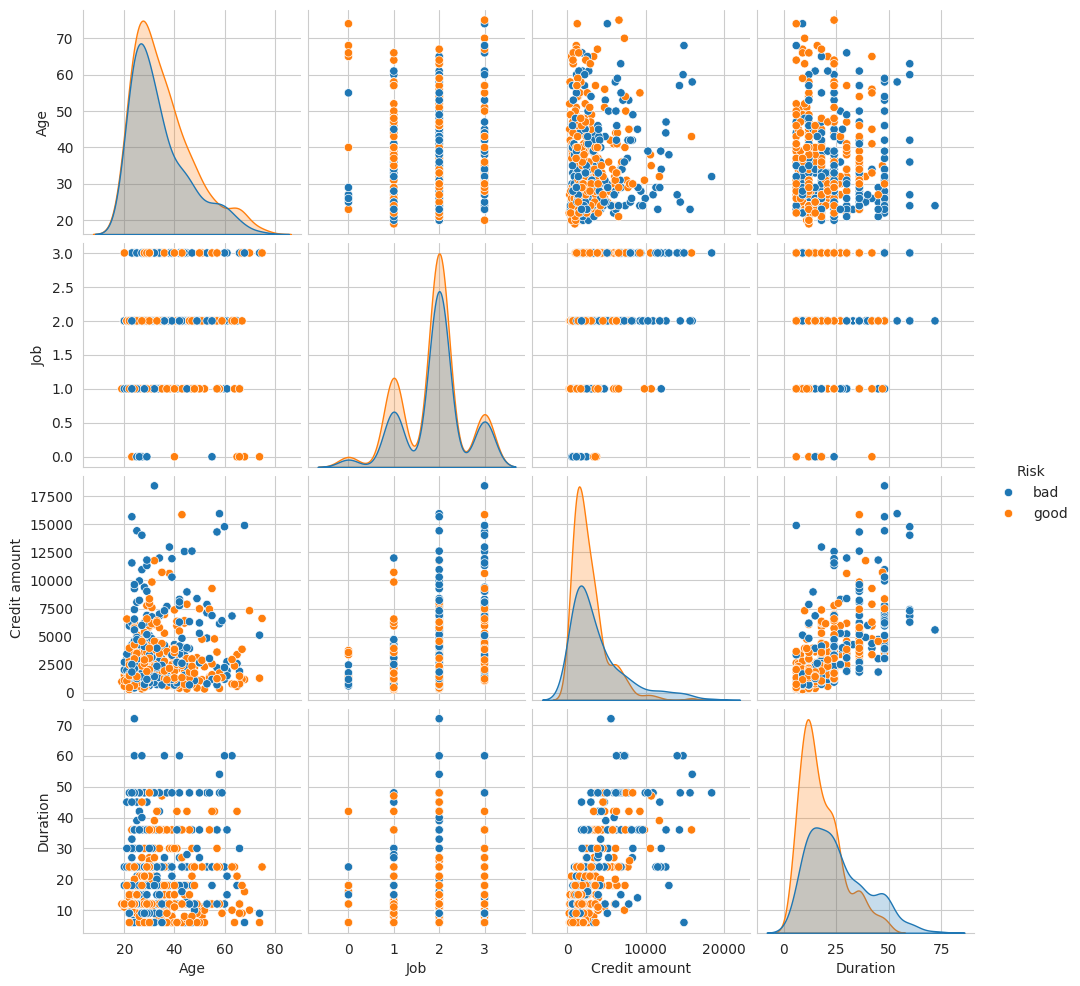

In [122]:
sns.pairplot(master_df,hue = "Risk")

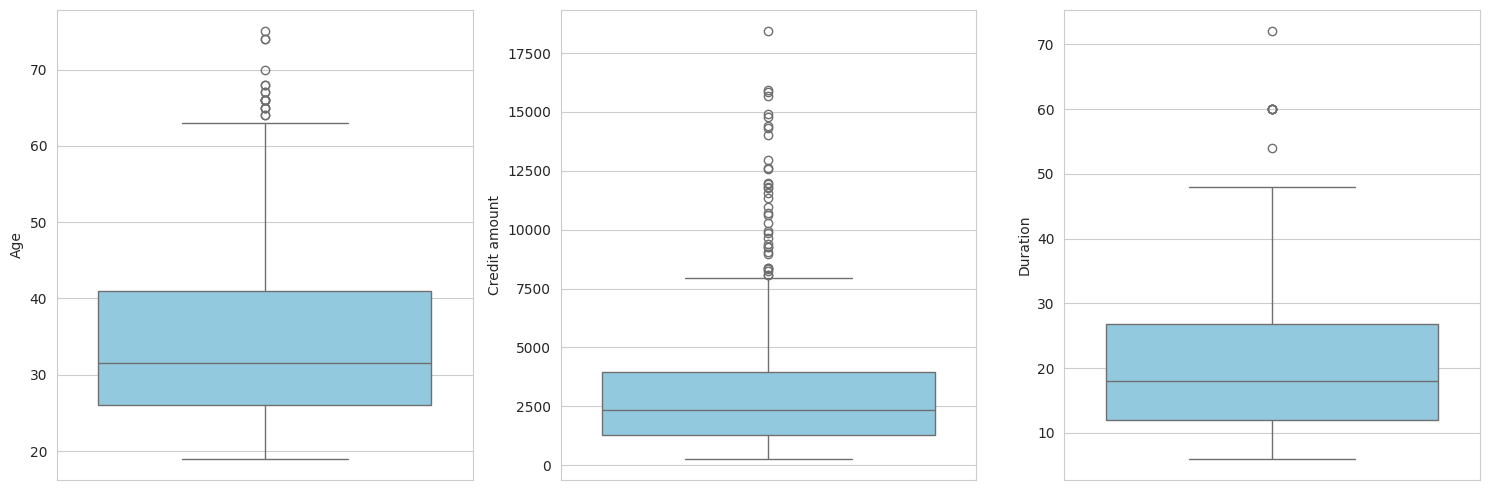

In [123]:
plt.figure(figsize = (15,5))
for i,col in enumerate(["Age","Credit amount","Duration"]):
    plt.subplot(1,3,i+1)
    sns.boxplot(y = master_df[col],color = "skyblue")
plt.tight_layout()
plt.show()

In [124]:
master_df.query("Duration > = 60")

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
18,63,male,2,own,little,little,6836,60,business,bad
176,24,female,3,own,moderate,moderate,7408,60,car,bad
199,60,female,3,free,moderate,moderate,14782,60,vacation/others,bad
358,24,male,2,own,moderate,moderate,5595,72,radio/TV,bad
378,27,male,3,own,little,moderate,14027,60,car,bad
489,42,male,2,free,little,moderate,6288,60,education,bad
507,36,male,2,rent,little,little,7297,60,business,bad


In [125]:
categorical_cols = ["Sex","Job","Housing","Saving accounts","Checking account","Purpose"]

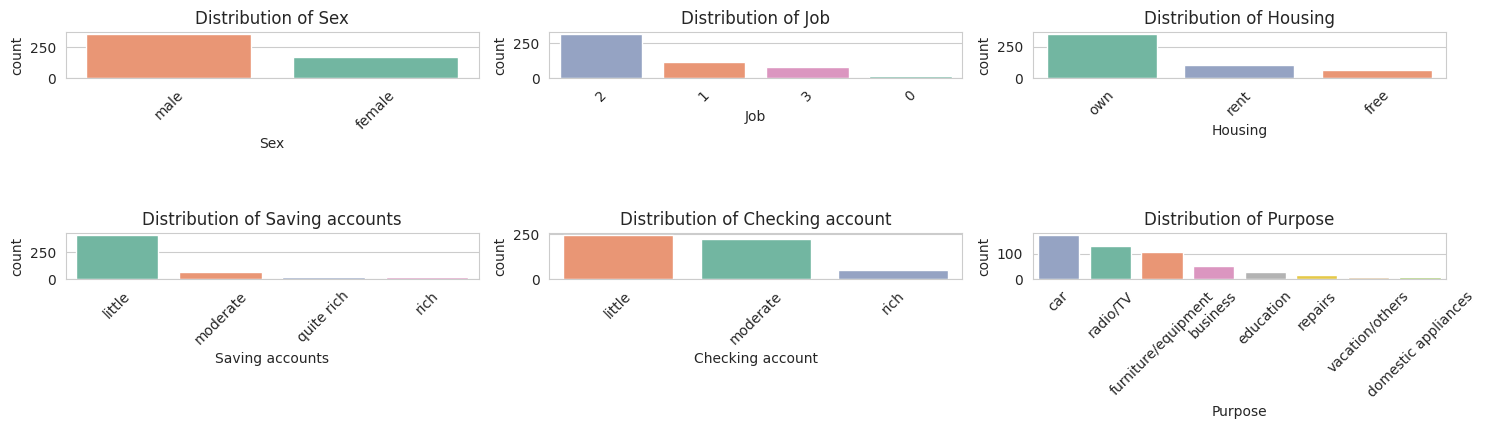

In [126]:
plt.figure(figsize = (15,5))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i+1)
    sns.countplot(
        data=master_df,
        x=col,
        hue=col,  # use the same variable as hue
        palette="Set2",
        order=master_df[col].value_counts().index,  # fixed missing .index
        legend=False  # avoid duplicate legends
    )
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: >

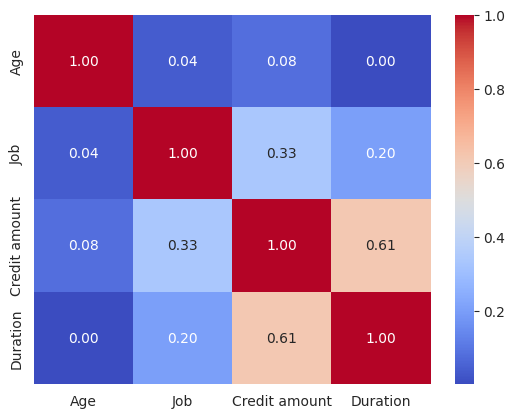

In [127]:
corr = master_df[["Age","Job","Credit amount","Duration"]].corr()
corr
sns.heatmap(corr,annot = True,cmap = "coolwarm",fmt = ".2f")

In [128]:
master_df.groupby("Job")["Credit amount"].mean()

Job
0    1767.857143
1    2250.715517
2    3129.130990
3    5648.784810
Name: Credit amount, dtype: float64

In [129]:
master_df.groupby("Sex")["Credit amount"].mean()

Sex
female    2937.202381
male      3440.833333
Name: Credit amount, dtype: float64

In [130]:
pd.pivot_table(master_df,values = "Credit amount",index = "Housing",columns = "Purpose")

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
Housing,,,,,,,,
free,4705.000000,5180.314286,NaN,5314.250000,4419.444444,2097.000000,1190.0,7842.666667
own,3725.973684,3120.485437,1333.5,2625.076923,3031.100000,2307.613861,2993.5,10321.833333
rent,6180.833333,3398.285714,NaN,2627.857143,2890.285714,2138.000000,2384.0,NaN


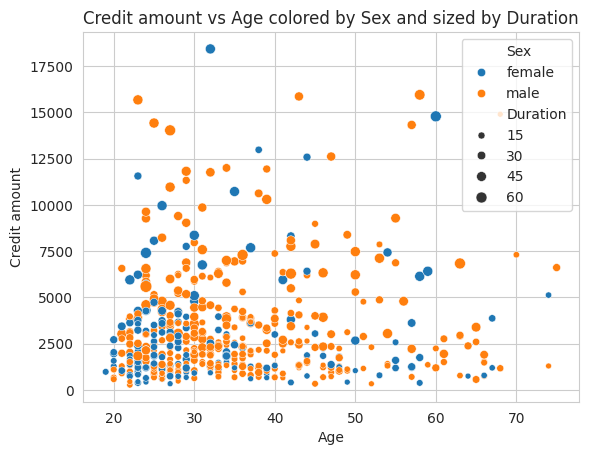

In [131]:
sns.scatterplot(data = master_df,x = "Age",y = "Credit amount",hue = "Sex",size = "Duration")
plt.title("Credit amount vs Age colored by Sex and sized by Duration")
plt.show()

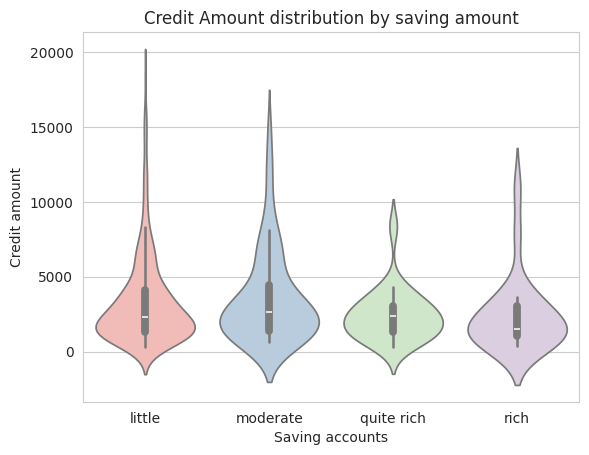

In [132]:
sns.violinplot(data = master_df,x = "Saving accounts",y = "Credit amount",hue = "Saving accounts",palette = "Pastel1",legend = False)
plt.title("Credit Amount distribution by saving amount")
plt.show()

In [133]:
master_df["Risk"].value_counts(normalize = True)*100

Risk
good    55.747126
bad     44.252874
Name: proportion, dtype: float64

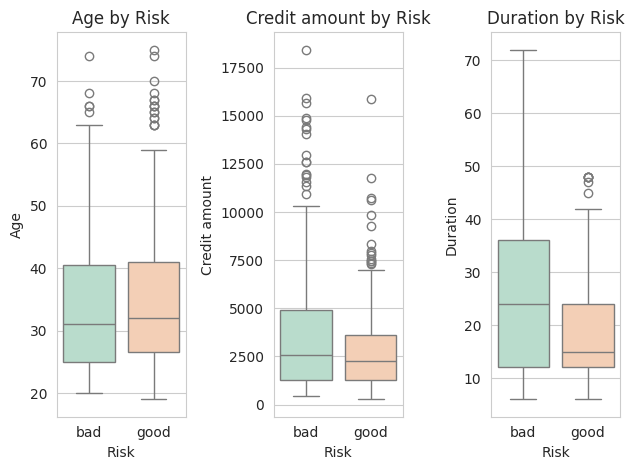

In [134]:
for i,col in enumerate(["Age","Credit amount","Duration"]):
    plt.subplot(1,3,i+1)
    sns.boxplot(data = master_df,x = "Risk",hue = "Risk",y = col,palette = "Pastel2",legend = False)
    plt.title(f"{col} by Risk")
plt.tight_layout()
plt.show()

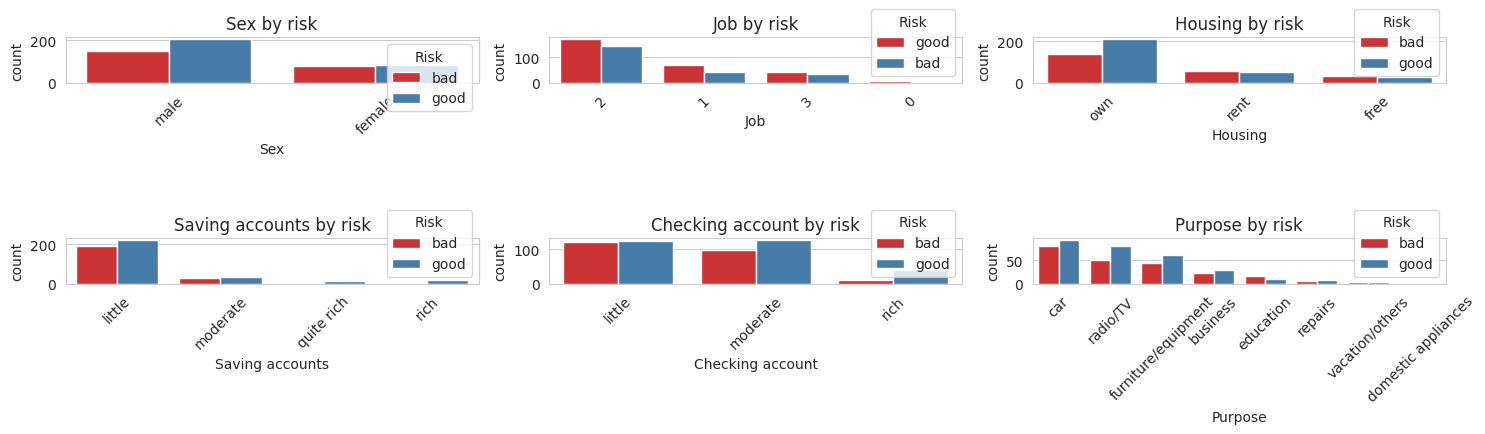

In [135]:
plt.figure(figsize = (15,5))
for i,col in enumerate(categorical_cols):
    plt.subplot(3,3,i+1)
    sns.countplot(data = master_df,x = col,hue = "Risk",palette = "Set1",order = master_df[col].value_counts().index)
    plt.title(f"{col} by risk")
    plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [136]:
features = ["Age","Sex","Job","Housing","Saving accounts","Checking account","Credit amount","Duration","Purpose"]

In [137]:
target = "Risk"

In [138]:
df_model = master_df[features+[target]].copy()

In [139]:
df_model.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,female,2,own,little,moderate,5951,48,radio/TV,bad
1,45,male,2,free,little,little,7882,42,furniture/equipment,good
2,53,male,2,free,little,little,4870,24,car,bad
3,35,male,3,rent,little,moderate,6948,36,car,good
4,28,male,3,own,little,moderate,5234,30,car,bad


In [140]:
from sklearn.preprocessing import LabelEncoder
import joblib

In [141]:
cat_column = df_model.select_dtypes(include = "object").columns.drop("Risk")

In [142]:
le_dict = {}

In [143]:
for col in cat_column:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    le_dict = le
    joblib.dump(le,f"{col}_encode_pkl")

In [144]:
le_target = LabelEncoder()

In [145]:
df_model[target] = le_target.fit_transform(df_model[target])

In [146]:
df_model[target].value_counts()

Risk
1    291
0    231
Name: count, dtype: int64

In [147]:
joblib.dump(le_target,"target_encoder.pkl")

['target_encoder.pkl']

In [148]:
df_model.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,0,2,1,0,1,5951,48,5,0
1,45,1,2,0,0,0,7882,42,4,1
2,53,1,2,0,0,0,4870,24,1,0
3,35,1,3,2,0,1,6948,36,1,1
4,28,1,3,1,0,1,5234,30,1,0


In [149]:
from sklearn.model_selection import train_test_split

In [150]:
X = df_model.drop(target,axis = 1)

In [151]:
y = df_model[target]

In [152]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y,random_state= 1)

In [153]:
X_test.shape

(105, 9)

In [154]:
def train_model(model, param_grid, X_train, y_train, X_test, y_test):
    # Define Stratified K-Fold
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use Stratified CV in GridSearch
    grid = GridSearchCV(
        model,
        param_grid,
        cv=stratified_cv,
        scoring="roc_auc",
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    return best_model, acc, grid.best_params_

# Decision Tree

In [155]:
dt = DecisionTreeClassifier(random_state = 1,class_weight = "balanced")
dt_param_grid = {
    "max_depth":[3,5,7,10,None],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[1,2,4]
}

In [156]:
best_dt,acc_dt,params_dt = train_model(dt,dt_param_grid,X_train,y_train,X_test,y_test)

In [157]:
print("Decision Tree Accuracy",acc_dt)

Decision Tree Accuracy 0.6095238095238096


In [158]:
print("Best parameters",params_dt)

Best parameters {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


# Random Forest

In [159]:
rf = RandomForestClassifier(random_state = 1,class_weight = "balanced",n_jobs = -1)

In [160]:
rf_param_grid = {
    "n_estimators":[100,200],
    "max_depth": [5,7,10,None],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[1,2,4]
}

In [161]:
best_rf,acc_rf,param_rf = train_model(rf,rf_param_grid,X_train,y_train,X_test,y_test)

In [162]:
print("Random forest accuracy",acc_rf)

Random forest accuracy 0.638095238095238


In [163]:
print("Best params",param_rf)

Best params {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


# Extra Tree

In [164]:
et = ExtraTreesClassifier(random_state = 1,class_weight = "balanced",n_jobs = -1)

In [165]:
et_param_grid = {
    "n_estimators":[100,200],
    "max_depth": [5,7,10,None],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[1,2,4]
}

In [166]:
best_et,acc_et,params_et = train_model(et,et_param_grid,X_train,y_train,X_test,y_test)

In [167]:
print("accuracy",acc_et)

accuracy 0.6571428571428571


In [168]:
print("Best params",params_et)

Best params {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


# XGB

In [169]:
xgb = XGBClassifier(random_state = 1,scale_pos_weight = (y_train==0).sum()/(y_train == 1).sum(),eval_metric = "logloss")

In [170]:
xgb_param_grid = {
    "n_estimators":[100,200],
    "max_depth": [3,5,7],
    "learning_rate":[0.01,0.1,0.2],
    "subsample":[0.7,1],
    "colsample_bytree":[0.7,1]
}

In [171]:
best_xgb,acc_xgb,params_xgb = train_model(xgb,xgb_param_grid,X_train,y_train,X_test,y_test)

In [172]:
print("accuracy",acc_xgb)

accuracy 0.6666666666666666


In [173]:
print("Best_params",params_xgb)

Best_params {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


XGB is best model with the highest accuracy of 0.667


In [174]:
from xgboost import XGBClassifier
import joblib

# Train final model with best params (from GridSearchCV)
final_xgb = XGBClassifier(
    random_state=1,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    eval_metric="logloss",
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=0.7
)

final_xgb.fit(X_train, y_train)

# Save the model for later use
joblib.dump(final_xgb, "credit_risk_model.pkl")

['credit_risk_model.pkl']

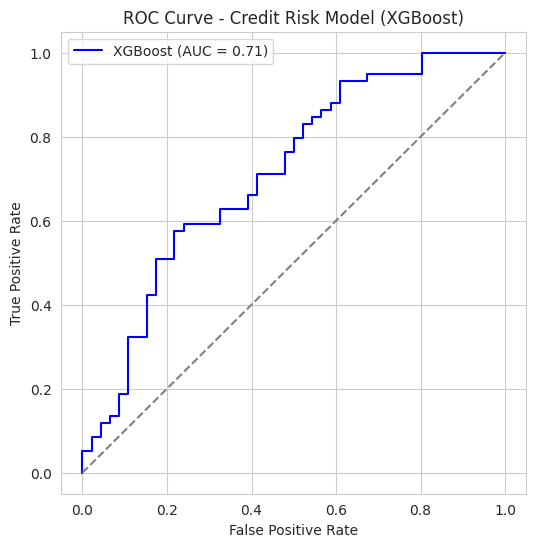

In [175]:
y_pred_prob = final_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.2f})", color="blue")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Credit Risk Model (XGBoost)")
plt.legend()
plt.show()

# Feature Selection 

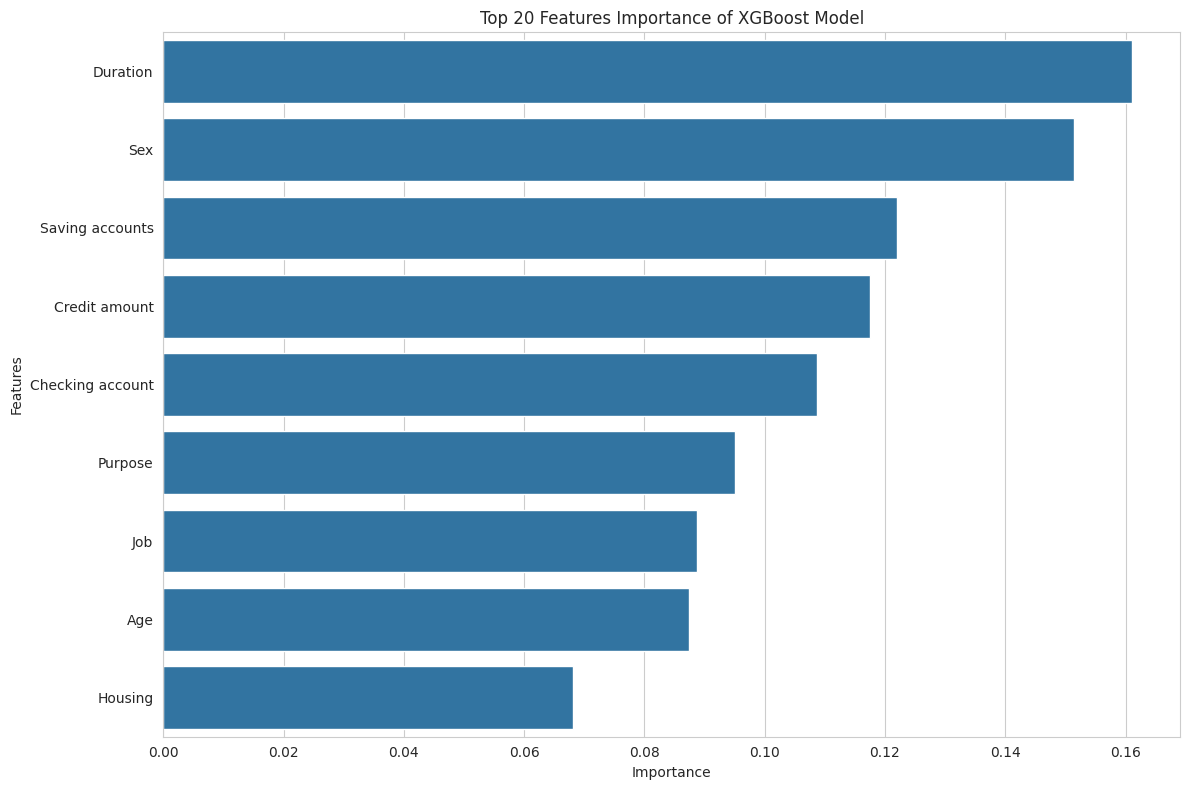

In [176]:
feature_importance = pd.DataFrame({
    'feature':X_train.columns,
    'importance':final_xgb.feature_importances_
}).sort_values('importance',ascending = False)
top_20_features = feature_importance.head(20)

plt.figure(figsize = (12,8))
sns.barplot(x='importance',y='feature',data = top_20_features)
plt.title('Top 20 Features Importance of XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
          

In [177]:
top_20_features

,feature,importance
7,Duration,0.161003
1,Sex,0.151366
4,Saving accounts,0.122065
6,Credit amount,0.117474
5,Checking account,0.108713
8,Purpose,0.095078
2,Job,0.088755
0,Age,0.087456
3,Housing,0.068089


# Deep learning

In [182]:
# Create a dictionary to store info needed for embedding layers
categorical_features = categorical_cols
cat_info = {
    col: df_model[col].nunique() for col in categorical_features
}

def build_credit_risk_model(features, cat_features_info):
    # Create input layers for numerical and categorical features
    num_input = keras.Input(shape=(len(features),), name='numerical_input')
    cat_inputs = [keras.Input(shape=(1,), name=f'cat_input_{name}') for name in cat_features_info]

    # Create embedding layers for each categorical feature
    embedding_layers = []
    for i, (name, num_categories) in enumerate(cat_features_info.items()):
        # Use a rule of thumb for embedding dimension
        embedding_dim = min(50, (num_categories // 2) + 1)
        # Fix: Replace spaces in the column name with underscores for a valid scope name
        valid_name = name.replace(" ", "_")
        embedding_layers.append(
            layers.Embedding(
                input_dim=num_categories,
                output_dim=embedding_dim,
                name=f'embedding_{valid_name}'
            )(cat_inputs[i])
        )
    
    # Flatten the embedding layers' output
    embedding_outputs = [layers.Flatten()(emb) for emb in embedding_layers]
    
    # Concatenate all inputs: numerical and flattened embeddings
    concatenated_inputs = layers.concatenate([num_input] + embedding_outputs)

    # Add a few dense hidden layers for the DNN
    x = layers.Dense(128, activation='relu')(concatenated_inputs)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Final output layer for binary classification (0 or 1)
    output = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
    
    # Create and compile the model
    model = keras.Model(inputs=[num_input] + cat_inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

# Function to prepare data in the list format needed for the DNN
def prepare_data_for_dnn(df, features, cat_features):
    num_data = df[features].values
    cat_data = [df[col].values.reshape(-1, 1) for col in cat_features]
    return [num_data] + cat_data

In [183]:
# Prepare your training and test data for the DNN model
X_train_dnn = prepare_data_for_dnn(X_train, features, categorical_features)
X_test_dnn = prepare_data_for_dnn(X_test, features, categorical_features)

# Build, train, and evaluate the DNN model
dnn_model = build_credit_risk_model(features, cat_info)
dnn_model.fit(X_train_dnn, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=0)

loss, accuracy, auc = dnn_model.evaluate(X_test_dnn, y_test, verbose=0)
print(f"Deep Neural Network Test Accuracy: {accuracy:.4f}")
print(f"Deep Neural Network Test loss: {loss:.4f}")
print(f"Deep Neural Network Test AUC: {auc:.4f}")

2025-09-24 10:30:35.213848: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Deep Neural Network Test Accuracy: 0.5619
Deep Neural Network Test loss: 0.6856
Deep Neural Network Test AUC: 0.5000


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


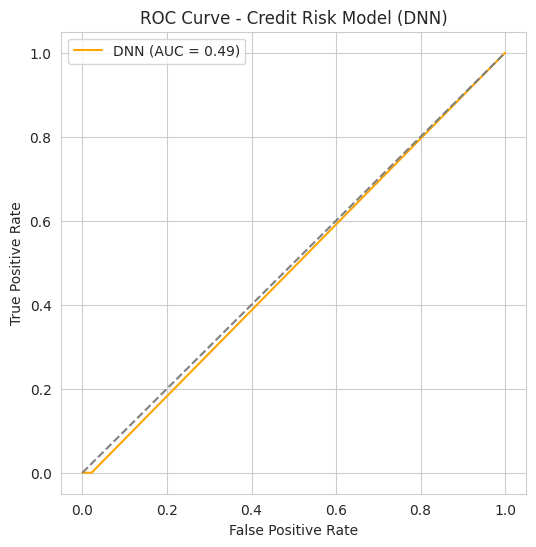

In [184]:
y_pred_prob_dnn = dnn_model.predict(X_test_dnn)[:, 0]
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_prob_dnn)
auc_score_dnn = roc_auc_score(y_test, y_pred_prob_dnn)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_dnn, tpr_dnn, label=f"DNN (AUC = {auc_score_dnn:.2f})", color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Credit Risk Model (DNN)")
plt.legend()
plt.show()

In [185]:
import pandas as pd

def predict_applicant(applicant_data, model):
    """
    applicant_data: dictionary with applicant features
    model: trained ML model
    """
    # Convert input into DataFrame
    df = pd.DataFrame([applicant_data])
    
    # Apply same preprocessing as training data (encoding/scaling if used)
    # Example: encoding categorical variables
    df = pd.get_dummies(df)
    df = df.reindex(columns=X_train.columns, fill_value=0)  # align with training features
    
    # Make prediction
    pred = model.predict(df)[0]
    proba = model.predict_proba(df)[0][1]  # probability of being 'Good'
    
    if pred == 1:
        return f"Prediction: Good Applicant ✅ (Confidence: {proba:.2f})"
    else:
        return f"Prediction: Bad Applicant ❌ (Confidence: {1-proba:.2f})"


In [186]:
# Load saved model
model = joblib.load("credit_risk_model.pkl")

# Example applicant (replace values as needed)
new_applicant = {
    "Age": 60,
    "Sex": "female",
    "Job": 2,
    "Housing": "own",
    "Saving accounts": "rich",
    "Checking account": "moderate",
    "Credit amount": 1500,
    "Duration": 19,
    "Purpose": "furniture"
}

print(predict_applicant(new_applicant, model))

Prediction: Bad Applicant ❌ (Confidence: 0.63)


In [187]:
good_applicant = {
    "Age": 40,
    "Sex": "female",
    "Job": 2,
    "Housing": "own",
    "Saving accounts": "rich",
    "Checking account": "moderate",
    "Credit amount": 15,
    "Duration": 1,
    "Purpose": "furniture"
}
print(predict_applicant(good_applicant,model))

Prediction: Good Applicant ✅ (Confidence: 0.96)
